In [1]:
import sys
sys.path.append('../')

import torch as tc
import numpy as np
import matplotlib.pyplot as plt

import gpytorch

from rcgp.experimental import SpatioTemporalRCGP
from rcgp.kernels import Matern32Kernel

from rcgp.weight_functions import IMQ, partial_y_IMQ

In [2]:
def generate_data(lengthscale=0.4, magnitude=2., var_y = 0.02):
    tc.manual_seed(42)  # For reproducibility

    x = tc.linspace(0, 1, 100)  # Same points for training and testing
    # Define known kernel parameters
    kernel = Matern32Kernel(lengthscale=tc.tensor(lengthscale), magnitude=tc.tensor(magnitude))

    cov_matrix = kernel.forward(x.reshape(-1,1), x.reshape(-1,1)) + 1e-5 * tc.eye(len(x))
    mean = tc.zeros(x.shape)

    true_f = tc.distributions.MultivariateNormal(mean, cov_matrix).sample()
    true_f = true_f - true_f.mean()

    noise = tc.distributions.Normal(0, var_y).sample(true_f.shape)

    y = true_f + noise

    return x, y, true_f

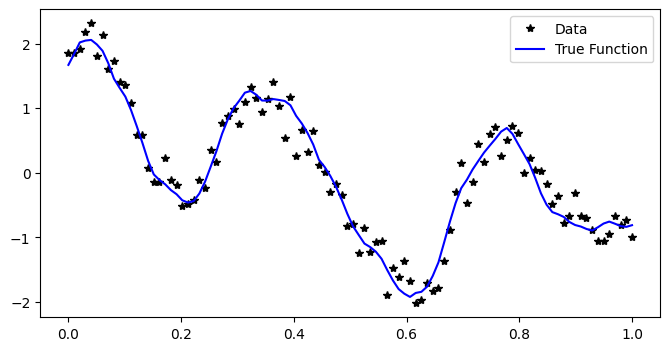

In [3]:
true_lengthscale=0.2
true_magnitude = 2.
true_var_y = 0.25
Xs, Ys, true_func = generate_data(lengthscale=true_lengthscale, magnitude=true_magnitude, var_y=true_var_y)
plt.figure(figsize=(8,4))
plt.plot(Xs, Ys, 'k*', label="Data")
plt.plot(Xs, true_func, 'b-', label="True Function")
plt.legend()

In [4]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(Xs, Ys, likelihood)

model.train()
likelihood.train()

optimizer = tc.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(200):  # Hyperparameter optimization loop
    optimizer.zero_grad()
    output = model(Xs)
    loss = -mll(output, Ys)
    loss.backward()
    optimizer.step()
    #print(f"Iteration {i + 1}/50 - Loss: {loss.item():.3f}")

# 5. Evaluate on the same points
model.eval()
likelihood.eval()

with tc.no_grad(), gpytorch.settings.fast_pred_var():
    gpytorch_pred = model(Xs)  # Predict on the training points

/opt/miniconda3/envs/RTGP/lib/python3.12/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [5]:
print("Learned Hyperparameters:")
for name, param in model.named_parameters():
    print(f"{name} : {param.item()}")
print("\nActual values:")
print("lengthscale : ", model.covar_module.base_kernel.lengthscale.item())
print("noise  variance: ", likelihood.noise_covar.noise.item())
print("magnitude : ", model.covar_module.outputscale.item())

Learned Hyperparameters:
likelihood.noise_covar.raw_noise : -3.0698769092559814
covar_module.raw_outputscale : 1.1355646848678589
covar_module.base_kernel.raw_lengthscale : -1.7901020050048828

Actual values:
lengthscale :  0.15438762307167053
noise  variance:  0.04548138007521629
magnitude :  1.4141358137130737


In [6]:
st_rcgp = SpatioTemporalRCGP(ts=Xs.reshape(-1,1), grid=None, Ys=Ys.reshape(-1,1), p=1)

st_rcgp.var_y = likelihood.noise_covar.noise.item()
st_rcgp.temporal_lengthscale = model.covar_module.base_kernel.lengthscale.item()
st_rcgp.temporal_magnitude = model.covar_module.outputscale.item()

with tc.no_grad():
    st_rcgp.deactivate_robustness()
    pred_st_rcgp, std_st_rcgp, energies, Ws = st_rcgp.forward()
    pred_st_rcgp = pred_st_rcgp.squeeze()
    std_st_rcgp = std_st_rcgp.squeeze()

All mean values within 5e-05 error margin in absolute difference ?  True
All std values within 5e-05 error margin in absolute difference ?  True


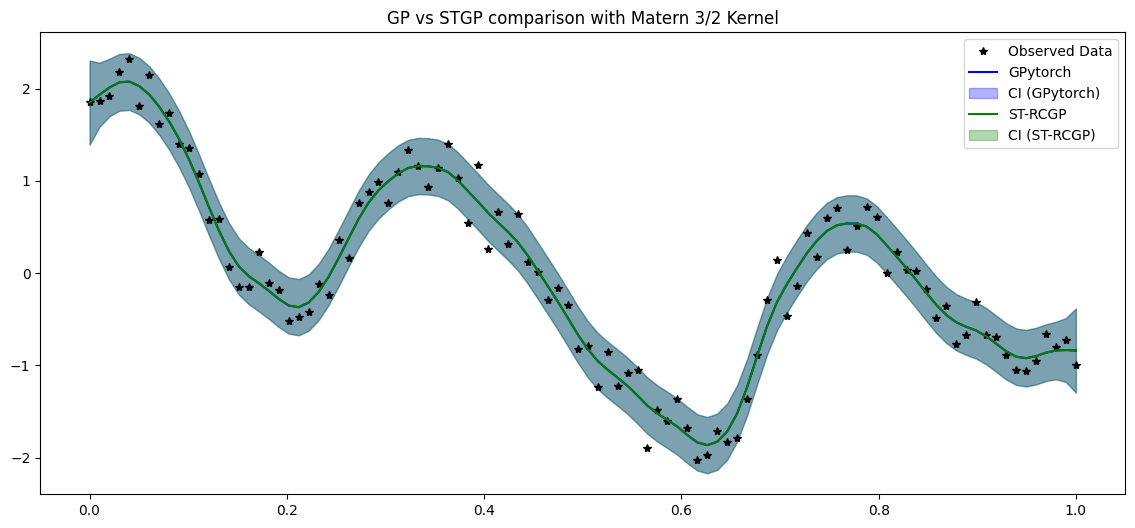

In [7]:
plt.figure(figsize=(14,6))

#Data and True Function
plt.plot(Xs.numpy(), Ys.numpy(), 'k*', label='Observed Data')

#GPytorch
plt.plot(Xs.numpy(), gpytorch_pred.mean.numpy(), 'b', label='GPytorch')
plt.fill_between(Xs.numpy(), gpytorch_pred.mean.numpy() - 3 * gpytorch_pred.variance.sqrt().numpy(), gpytorch_pred.mean.numpy() + 3 * gpytorch_pred.variance.sqrt().numpy(), alpha=0.3, color='blue', label='CI (GPytorch)')

#ST-RCGP
plt.plot(Xs.numpy(), pred_st_rcgp.squeeze().numpy(), color='green', label='ST-RCGP')
plt.fill_between(Xs.numpy(), pred_st_rcgp.squeeze().numpy() - 3 * std_st_rcgp.squeeze().numpy(), pred_st_rcgp.squeeze().numpy() + 3 * std_st_rcgp.squeeze().numpy(), color='green', alpha=0.3, label='CI (ST-RCGP)')

#Plotting
plt.title("GP vs STGP comparison with Matern 3/2 Kernel")
plt.legend()

#Quantitative comparions
err = 5e-5
print(f"All mean values within {err} error margin in absolute difference ? ", (np.abs(pred_st_rcgp.numpy() - gpytorch_pred.mean.numpy()) < err).all())
print(f"All std values within {err} error margin in absolute difference ? ", (np.abs(std_st_rcgp.numpy() - gpytorch_pred.variance.sqrt().numpy()) < err).all())

In [8]:
def rcgp(var_y, magnitude, lengthscale, grid, Ys, return_std=True):

    with tc.no_grad():
        matern_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=3/2))
        matern_kernel.base_kernel.lengthscale = tc.tensor(lengthscale)
        matern_kernel.outputscale = tc.tensor(magnitude)
        K = matern_kernel.forward(grid.reshape(-1,1), grid.reshape(-1,1))

    m = tc.zeros_like(Ys, dtype=tc.float32) + Ys.mean()

    beta= np.sqrt(var_y / 2)
    c= 1.
    
    w = IMQ(Y=Ys, m=m, beta=beta, c=c)
    partial_w = partial_y_IMQ(Y=Ys, m=m, beta=beta, c=c)

    J_w = tc.diag((var_y / 2) * w.flatten()**(-2))

    m_w = m + 2 * var_y * (w)**(-1) * partial_w

    A = tc.linalg.inv(K + var_y * J_w)

    mu_rcgp = m + K @ A @ (Ys - m_w)

    if return_std:
        Sigma = K @ A @ (var_y * J_w)
        std_rcgp = tc.sqrt(tc.diag(Sigma))
    
        return mu_rcgp.flatten(), std_rcgp

    else:
        return mu_rcgp.flatten()

In [9]:
st_rcgp_robust = SpatioTemporalRCGP(ts=Xs.reshape(-1,1), grid=None, Ys=Ys.reshape(-1,1), p=1)

st_rcgp_robust.var_y = likelihood.noise_covar.noise.item()
st_rcgp_robust.temporal_lengthscale = model.covar_module.base_kernel.lengthscale.item()
st_rcgp_robust.temporal_magnitude = model.covar_module.outputscale.item()

with tc.no_grad():
    st_rcgp_robust.activate_robustness(func='constant')
    st_rcgp.c = 1.
    st_rcgp.fixed_c()
    pred_st_rcgp_robust, std_st_rcgp_robust, energies_robust, Ws_robust = st_rcgp_robust.forward()
    pred_st_rcgp_robust = pred_st_rcgp_robust.squeeze()
    std_st_rcgp_robust = std_st_rcgp_robust.squeeze()

In [10]:
pred_rcgp, std_rcgp = rcgp(var_y=st_rcgp_robust.var_y.item(),
                           magnitude=st_rcgp_robust.temporal_magnitude.item(),
                           lengthscale=st_rcgp_robust.temporal_lengthscale.item(),
                           grid=Xs.reshape(-1,1),
                           Ys=Ys.reshape(-1,1))

Mean difference (mean, std):  tensor(2.6609e-05) tensor(7.9863e-07)


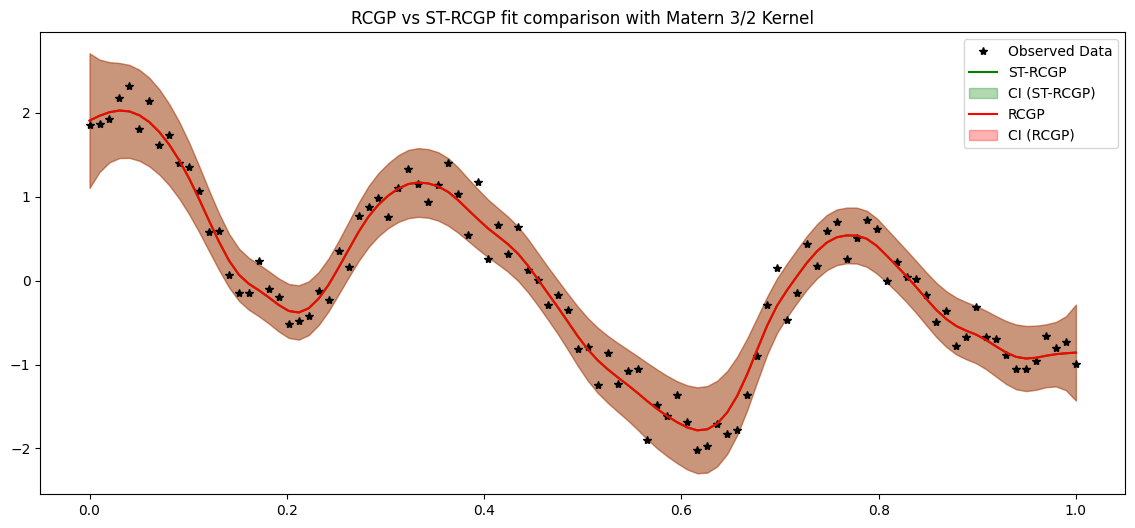

In [11]:
plt.figure(figsize=(14,6))

#Data and True Function
plt.plot(Xs.numpy(), Ys.numpy(), 'k*', label='Observed Data')

#ST-RCGP
plt.plot(Xs.numpy(), pred_st_rcgp_robust.squeeze().numpy(), color='green', label='ST-RCGP')
plt.fill_between(Xs.numpy(), pred_st_rcgp_robust.squeeze().numpy() - 3 * std_st_rcgp_robust.squeeze().numpy(), pred_st_rcgp_robust.squeeze().numpy() + 3 * std_st_rcgp_robust.squeeze().numpy(), color='green', alpha=0.3, label='CI (ST-RCGP)')

#RCGP
plt.plot(Xs.numpy(), pred_rcgp.squeeze().numpy(), color='red', label='RCGP')
plt.fill_between(Xs.numpy(), pred_rcgp.squeeze().numpy() - 3 * std_rcgp.squeeze().numpy(), pred_rcgp.squeeze().numpy() + 3 * std_rcgp.squeeze().numpy(), color='red', alpha=0.3, label='CI (RCGP)')

#Plotting
plt.title("RCGP vs ST-RCGP fit comparison with Matern 3/2 Kernel")
plt.legend()

#Mean Difference
print("Mean difference (mean, std): ", np.abs(pred_rcgp - pred_st_rcgp_robust).mean(), np.abs(std_st_rcgp_robust - std_rcgp).mean())